<h1>Практическая работа №2<h1>
<h2>Выполнила: Бардасова Ирина<h2>
<h2>Группа: ББМО-02-22<h2/>
<h2>Номер в списке - 2. Вариант: 2 % 16 + 1 = 3<h2/>

In [1]:
# клонируем репозиторий с логами
!git clone https://github.com/logpai/loghub

Cloning into 'loghub'...
remote: Enumerating objects: 563, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 563 (delta 58), reused 58 (delta 49), pack-reused 476
Receiving objects: 100% (563/563), 7.32 MiB | 2.77 MiB/s, done.
Resolving deltas: 100% (259/259), done.


In [3]:
# импорт необходимых библиотек
import sqlite3
import csv
import re

# соединение с БД
conn = sqlite3.connect("log_data.db")
cursor = conn.cursor()

# создаем таблицы для каждого вида сообщений
for message_type in ["kernel_info", "app_fatal", "kernel_fatal", "discovery_warning", "mmcs_error"]:
    cursor.execute(f'''CREATE TABLE IF NOT EXISTS log_entries_{message_type} (
                        line_id INTEGER PRIMARY KEY,
                        label TEXT,
                        timestamp INTEGER,
                        date TEXT,
                        node TEXT,
                        event_timestamp TEXT,
                        node_repeat TEXT,
                        event_type TEXT,
                        component TEXT,
                        level TEXT,
                        content TEXT,
                        event_id TEXT,
                        event_template TEXT
                    )''')

# паттерны
patterns = {
    "log_entries_kernel_info": r'(\d+),(-),(\d+),(.+),(.+),(.+),(.+),(.+),KERNEL,INFO,(.+),(.+)',
    "log_entries_app_fatal": r'(\d+),(APPREAD),(\d+),(.+),(.+),(.+),(.+),(.+),APP,FATAL,(.+)',
    "log_entries_kernel_fatal": r'(\d+),(-),(\d+),(.+),(.+),(.+),(.+),(.+),KERNEL,FATAL,(.+)',
    "log_entries_discovery_warning": r'(\d+),(-),(\d+),(.+),(.+),(.+),(.+),(.+),DISCOVERY,WARNING,(.+)',
    "log_entries_mmcs_error": r'(\d+),(-),(\d+),(.+),(.+),(.+),(.+),(.+),MMCS,ERROR,(.+)'
}

# открываем файл и считываем строки
with open('BGL_2k.log_structured.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')  # резделитель - запятая
    next(reader)  # пропускаем шапку

    for row in reader:
        if len(row) == 13:  # 13 полей
            line_id = row[0]
            label = row[1]
            timestamp = int(row[2])
            date = row[3]
            node = row[4]
            event_timestamp = row[5]
            node_repeat = row[6]
            event_type = row[7]
            component = row[8]
            level = row[9]
            content = row[10]
            event_id = row[11]
            event_template = row[12]

            # Определите тип сообщения
            message_type = None
            for table_name, pattern in patterns.items():
                if re.match(pattern, ",".join(row)):
                    message_type = table_name
                    break

            # Вставьте данные в соответствующую таблицу
            if message_type:
                cursor.execute(
                    f"INSERT INTO {message_type} (line_id, label, timestamp, date, node, event_timestamp, node_repeat, event_type, component, level, content, event_id, event_template) "
                    "VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)",
                    (line_id, label, timestamp, date, node, event_timestamp, node_repeat, event_type, component, level, content, event_id, event_template)
                )
        else:
            print(f"Некорректная строка: {row}")

# сохранение изменеий в БД
conn.commit()
# Закрытие соединения с БД
conn.close()

Проверим, чтобы таблицы заполнились данными из файла.

In [4]:
conn = sqlite3.connect("log_data.db")
cursor = conn.cursor()

# проверка таблицы log_entries_kernel_info
cursor.execute("SELECT COUNT(*) FROM log_entries_kernel_info")
count_kernel_info = cursor.fetchone()[0]
print(f"В таблице log_entries_kernel_info есть {count_kernel_info} записей.")

# проверка таблицы log_entries_app_fatal
cursor.execute("SELECT COUNT(*) FROM log_entries_app_fatal")
count_app_fatal = cursor.fetchone()[0]
print(f"В таблице log_entries_app_fatal есть {count_app_fatal} записей.")

# проверка таблицы log_entries_kernel_fatal
cursor.execute("SELECT COUNT(*) FROM log_entries_kernel_fatal")
count_kernel_fatal = cursor.fetchone()[0]
print(f"В таблице log_entries_kernel_fatal есть {count_kernel_fatal} записей.")

# проверка таблицы log_entries_discovery_warning
cursor.execute("SELECT COUNT(*) FROM log_entries_discovery_warning")
count_discovery_warning = cursor.fetchone()[0]
print(f"В таблице log_entries_discovery_warning есть {count_discovery_warning} записей.")

# проверка таблицы log_entries_mmcs_error
cursor.execute("SELECT COUNT(*) FROM log_entries_mmcs_error")
count_mmcs_error = cursor.fetchone()[0]
print(f"В таблице log_entries_mmcs_error есть {count_mmcs_error} записей.")

conn.close()

В таблице log_entries_kernel_info есть 1580 записей.
В таблице log_entries_app_fatal есть 3 записей.
В таблице log_entries_kernel_fatal есть 125 записей.
В таблице log_entries_discovery_warning есть 6 записей.
В таблице log_entries_mmcs_error есть 35 записей.


**Нормализация.**
Выполним нормализацию данных: исключим столбцы Label и EventTemplate для уменьшения избыточности и оптимизации структуры БД.

In [5]:
conn = sqlite3.connect("log_data.db")
cursor = conn.cursor()

# создание нормализованных таблиц
cursor.execute('''CREATE TABLE IF NOT EXISTS normalized_log_entries_kernel_info (
                    line_id INTEGER PRIMARY KEY,
                    timestamp INTEGER,
                    date TEXT,
                    node TEXT,
                    event_timestamp TEXT,
                    node_repeat TEXT,
                    event_type TEXT,
                    component TEXT,
                    level TEXT,
                    content TEXT,
                    event_id TEXT
                )''')

cursor.execute('''CREATE TABLE IF NOT EXISTS normalized_log_entries_app_fatal (
                    line_id INTEGER PRIMARY KEY,
                    timestamp INTEGER,
                    date TEXT,
                    node TEXT,
                    event_timestamp TEXT,
                    node_repeat TEXT,
                    event_type TEXT,
                    component TEXT,
                    level TEXT,
                    content TEXT,
                    event_id TEXT
                )''')

cursor.execute('''CREATE TABLE IF NOT EXISTS normalized_log_entries_kernel_fatal (
                    line_id INTEGER PRIMARY KEY,
                    timestamp INTEGER,
                    date TEXT,
                    node TEXT,
                    event_timestamp TEXT,
                    node_repeat TEXT,
                    event_type TEXT,
                    component TEXT,
                    level TEXT,
                    content TEXT,
                    event_id TEXT
                )''')

cursor.execute('''CREATE TABLE IF NOT EXISTS normalized_log_entries_discovery_warning (
                    line_id INTEGER PRIMARY KEY,
                    timestamp INTEGER,
                    date TEXT,
                    node TEXT,
                    event_timestamp TEXT,
                    node_repeat TEXT,
                    event_type TEXT,
                    component TEXT,
                    level TEXT,
                    content TEXT,
                    event_id TEXT
                )''')

cursor.execute('''CREATE TABLE IF NOT EXISTS normalized_log_entries_mmcs_error (
                    line_id INTEGER PRIMARY KEY,
                    timestamp INTEGER,
                    date TEXT,
                    node TEXT,
                    event_timestamp TEXT,
                    node_repeat TEXT,
                    event_type TEXT,
                    component TEXT,
                    level TEXT,
                    content TEXT,
                    event_id TEXT
                )''')

# перенос данных в новые таблицы
cursor.execute('''INSERT INTO normalized_log_entries_kernel_info (timestamp, date, node, event_timestamp, node_repeat, event_type, component, level, content, event_id)
                  SELECT timestamp, date, node, event_timestamp, node_repeat, event_type, component, level, content, event_id
                  FROM log_entries_kernel_info''')

cursor.execute('''INSERT INTO normalized_log_entries_app_fatal (timestamp, date, node, event_timestamp, node_repeat, event_type, component, level, content, event_id)
                  SELECT timestamp, date, node, event_timestamp, node_repeat, event_type, component, level, content, event_id
                  FROM log_entries_app_fatal''')

cursor.execute('''INSERT INTO normalized_log_entries_kernel_fatal (timestamp, date, node, event_timestamp, node_repeat, event_type, component, level, content, event_id)
                  SELECT timestamp, date, node, event_timestamp, node_repeat, event_type, component, level, content, event_id
                  FROM log_entries_kernel_fatal''')

cursor.execute('''INSERT INTO normalized_log_entries_discovery_warning (timestamp, date, node, event_timestamp, node_repeat, event_type, component, level, content, event_id)
                  SELECT timestamp, date, node, event_timestamp, node_repeat, event_type, component, level, content, event_id
                  FROM log_entries_discovery_warning''')

cursor.execute('''INSERT INTO normalized_log_entries_mmcs_error (timestamp, date, node, event_timestamp, node_repeat, event_type, component, level, content, event_id)
                  SELECT timestamp, date, node, event_timestamp, node_repeat, event_type, component, level, content, event_id
                  FROM log_entries_mmcs_error''')

conn.commit()
conn.close()

 Проверим первые строки новых таблиц.

In [7]:
# список нормализованных таблиц
table_names = ["normalized_log_entries_kernel_info", "normalized_log_entries_app_fatal", "normalized_log_entries_kernel_fatal", "normalized_log_entries_discovery_warning", "normalized_log_entries_mmcs_error"]

conn = sqlite3.connect("log_data.db")
cursor = conn.cursor()

# первые 5 строк таблиц
for table_name in table_names:
    print(f"Первые 5 строк из таблицы {table_name}:")
    cursor.execute(f"SELECT * FROM {table_name} LIMIT 5")
    rows = cursor.fetchall()
    for row in rows:
        print(row)

conn.close()

Первые 5 строк из таблицы normalized_log_entries_kernel_info:
(1, 1117838570, '2005.06.03', 'R02-M1-N0-C:J12-U11', '2005-06-03-15.42.50.675872', 'R02-M1-N0-C:J12-U11', 'RAS', 'KERNEL', 'INFO', 'instruction cache parity error corrected', 'E77')
(2, 1117838573, '2005.06.03', 'R02-M1-N0-C:J12-U11', '2005-06-03-15.42.53.276129', 'R02-M1-N0-C:J12-U11', 'RAS', 'KERNEL', 'INFO', 'instruction cache parity error corrected', 'E77')
(3, 1117838976, '2005.06.03', 'R02-M1-N0-C:J12-U11', '2005-06-03-15.49.36.156884', 'R02-M1-N0-C:J12-U11', 'RAS', 'KERNEL', 'INFO', 'instruction cache parity error corrected', 'E77')
(4, 1117838978, '2005.06.03', 'R02-M1-N0-C:J12-U11', '2005-06-03-15.49.38.026704', 'R02-M1-N0-C:J12-U11', 'RAS', 'KERNEL', 'INFO', 'instruction cache parity error corrected', 'E77')
(5, 1117842440, '2005.06.03', 'R23-M0-NE-C:J05-U01', '2005-06-03-16.47.20.730545', 'R23-M0-NE-C:J05-U01', 'RAS', 'KERNEL', 'INFO', '63543 double-hummer alignment exceptions', 'E3')
Первые 5 строк из таблицы nor

**Статистический анализ и виртуалзация.**
Проведём анализ уровней, частоты событий и компонентов. Также создадим сводную диаграмму для уровней и компонентов.

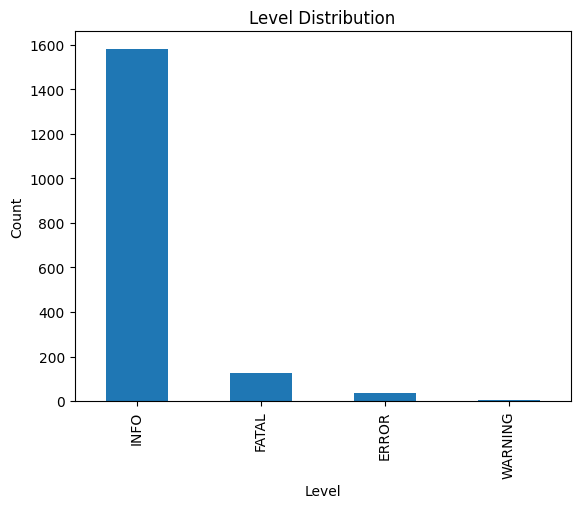

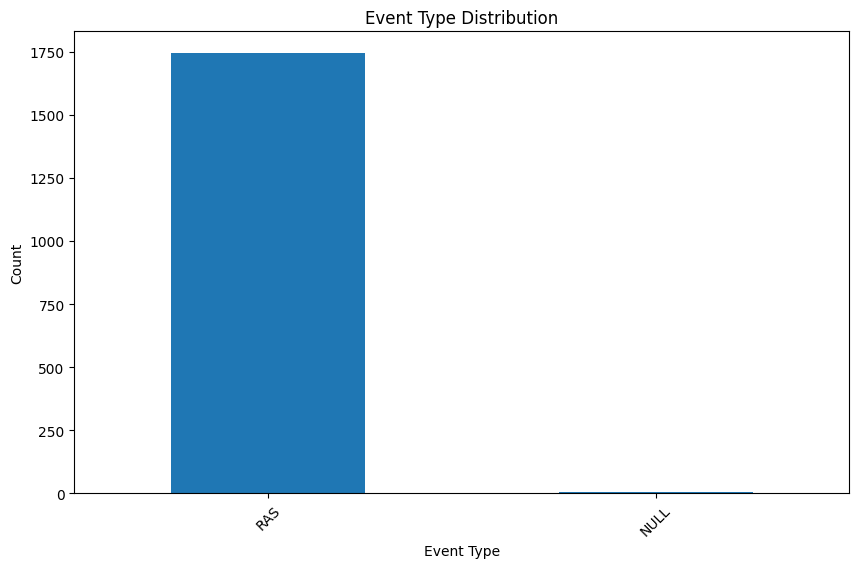

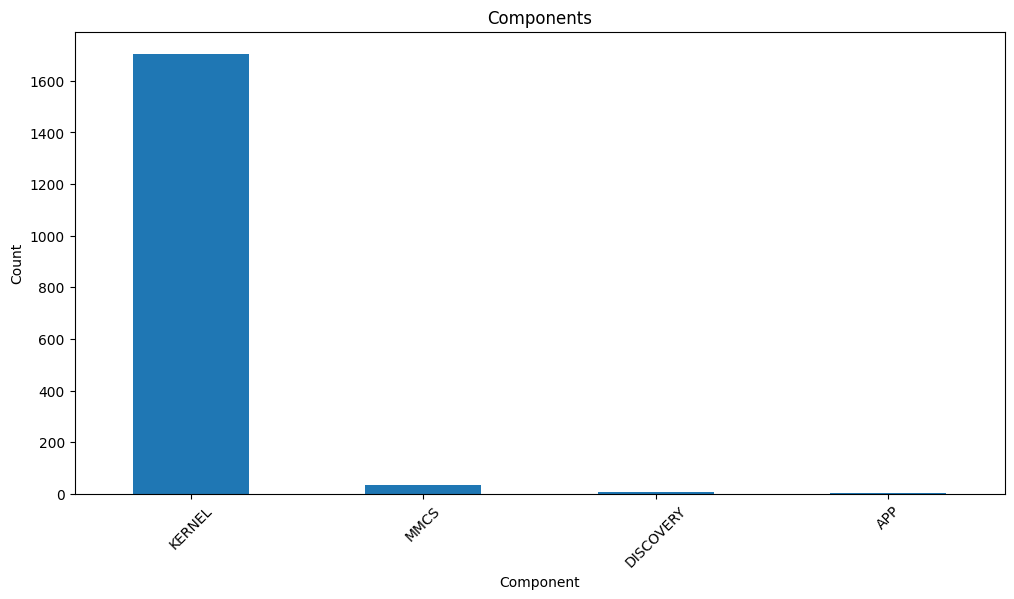

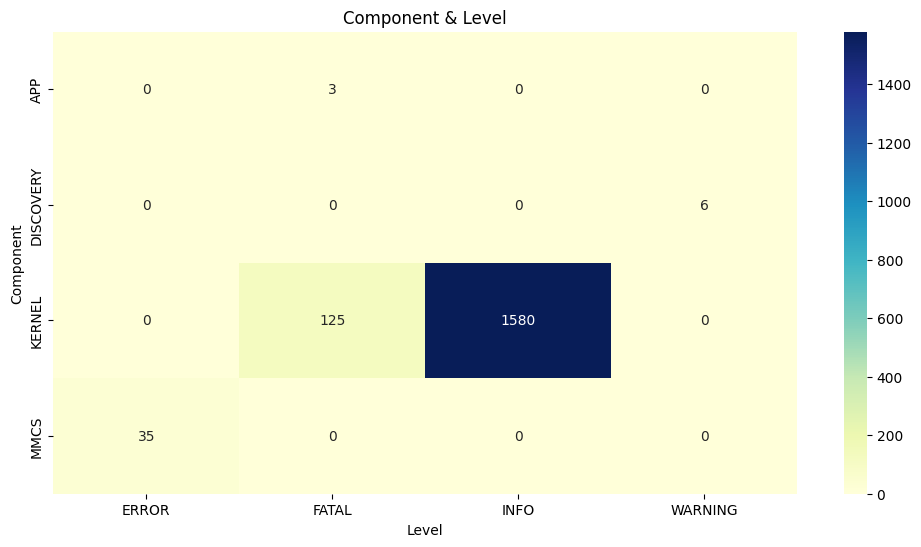

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

conn = sqlite3.connect("log_data.db")

# читаем данные из таблиц в датафрейм
logs_df = pd.read_sql_query("SELECT * FROM normalized_log_entries_kernel_info "
                           "UNION ALL "
                           "SELECT * FROM normalized_log_entries_app_fatal "
                           "UNION ALL "
                           "SELECT * FROM normalized_log_entries_kernel_fatal "
                           "UNION ALL "
                           "SELECT * FROM normalized_log_entries_discovery_warning "
                           "UNION ALL "
                           "SELECT * FROM normalized_log_entries_mmcs_error ", conn)

# анализ уровней логирования
log_level_counts = logs_df['level'].value_counts()
log_level_counts.plot(kind='bar')
plt.xlabel('Level')
plt.ylabel('Count')
plt.title('Level Distribution')
plt.show()

# анализ частоты определенных событий
event_type_counts = logs_df['event_type'].value_counts()
event_type_counts.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.title('Event Type Distribution')
plt.xticks(rotation=45)
plt.show()

# анализ компонентов
component_counts = logs_df['component'].value_counts()
component_counts[:20].plot(kind='bar', figsize=(12, 6))
plt.xlabel('Component')
plt.ylabel('Count')
plt.title('Components')
plt.xticks(rotation=45)
plt.show()

# анализ комбинации компонентов и уровней
import seaborn as sns
# cоздание сводной таблицы
pivot_table = logs_df.pivot_table(index='component', columns='level', aggfunc='size', fill_value=0)
# визуализация
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt='d')
plt.xlabel('Level')
plt.ylabel('Component')
plt.title('Component & Level')
plt.show()

conn.close()